<a href="https://colab.research.google.com/github/calamistratus/Houses_project/blob/main/Model_buildingipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

clear_output()

In [2]:
path = ''

df = pd.read_csv(path + 'fixed_df.csv')

In [3]:
df_dum = pd.get_dummies(df, drop_first=True)

train_dum = df_dum[~df_dum['SalePrice'].isnull()]
test_dum = df_dum[df_dum['SalePrice'].isnull()].drop('SalePrice', axis=1)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = train_dum.drop('SalePrice', axis=1)
y = train_dum['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler().fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.fit_transform(X)

scaled_test = scaler.transform(test_dum)

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

def test_model(model, sample=None, random_state=42, return_model=False):

  if sample:
    sub_df = pd.DataFrame(scaled_X_train)
    sub_df['goal'] = np.array(y_train)
    sub_df = sub_df.sample(frac=sample, random_state=42)

    model.fit(sub_df.drop('goal', axis=1), sub_df['goal'])
  else:
    model.fit(scaled_X_train, y_train)

  preds = model.predict(scaled_X_test)

  print('MAE:', mean_absolute_error(y_test, preds))
  print('MRSE:', np.sqrt(mean_squared_error(y_test, preds)))

  if return_model:
    return model

def test_grid(model, param_grid, sample=None, random_state=42, verbose=2, cv=3, return_model=False):
  grid = GridSearchCV(model, param_grid, cv=cv, verbose=verbose, scoring='neg_root_mean_squared_error')

  if sample:
    sub_df = pd.DataFrame(scaled_X_train)
    sub_df['goal'] = np.array(y_train)
    sub_df = sub_df.sample(frac=sample, random_state=random_state)

    grid.fit(sub_df.drop('goal', axis=1), sub_df['goal'])
  else:
    grid.fit(scaled_X_train, y_train)
  preds = grid.predict(scaled_X_test)

  print('MAE:', mean_absolute_error(y_test, preds))
  print('MRSE:', np.sqrt(mean_squared_error(y_test, preds)))
  print(grid.best_params_)

  if return_model:
    return grid

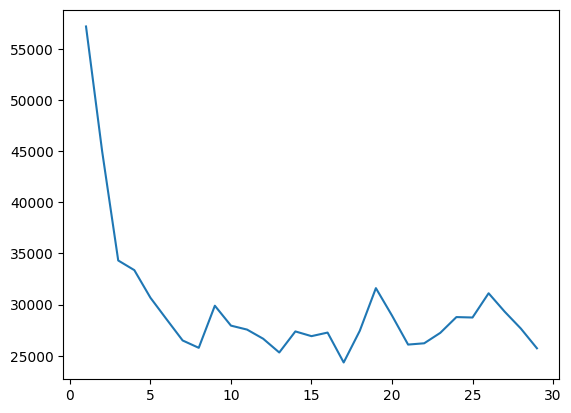

MAE: 20542.2966754373
MRSE: 32781.326231040075


In [8]:
from sklearn.tree import DecisionTreeRegressor

errors = []
nrange = list(range(1, 30))


for i in nrange:
  dtr = DecisionTreeRegressor(max_depth=i)
  dtr.fit(scaled_X_train, y_train)

  preds = dtr.predict(scaled_X_test)
  errors.append((mean_absolute_error(y_test, preds) +
                np.sqrt(mean_squared_error(y_test, preds))) / 2)

plt.plot(nrange, errors)
plt.show()

test_model(DecisionTreeRegressor(max_depth=12))   # Effective enough for its simplicity

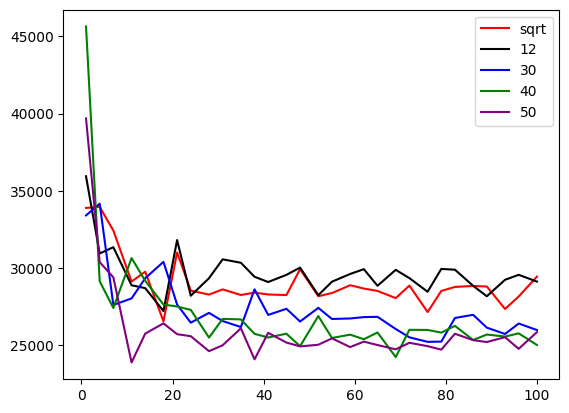

MAE: 17213.285332301133
MRSE: 32578.38713895823


In [9]:
from sklearn.ensemble import RandomForestRegressor

nrange = np.linspace(1, 100, 30).astype(int)
params = ['sqrt', 12, 30, 40, 50]

for j, c in zip(params, ['red', 'black', 'blue', 'green', 'purple']):
  errors = []
  for i in nrange:
    print(j, i, end='/')
    dtr = RandomForestRegressor(max_depth=12, n_estimators=i, max_features=j)
    dtr.fit(scaled_X_train, y_train)

    preds = dtr.predict(scaled_X_test)
    errors.append((mean_absolute_error(y_test, preds) +
                  np.sqrt(mean_squared_error(y_test, preds))) / 2)

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.show()

test_model(RandomForestRegressor(n_estimators=90, max_depth=12, max_features=50))   # Not too bad, long in training though

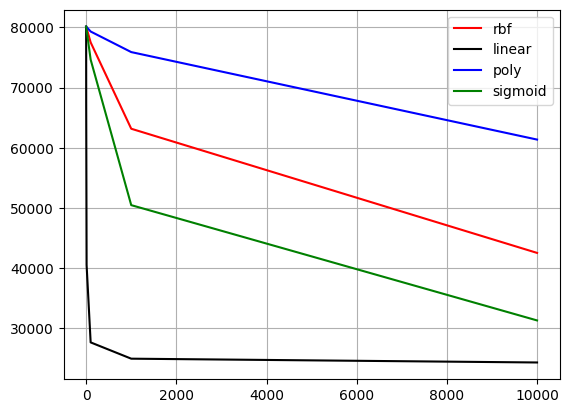

MAE: 17485.738667155776
MRSE: 31184.6340464421


In [20]:
from sklearn.svm import SVR

nrange = [.01, .1, 1, 10, 100, 1000, 10000]
params = ['rbf', 'linear', 'poly', 'sigmoid']

for j, c in zip(params, ['red', 'black', 'blue', 'green']):
  errors = []
  for i in nrange:
    print(j, i, end='/')

    svr = SVR(kernel=j, C=i)
    svr.fit(scaled_X_train, y_train)

    preds = svr.predict(scaled_X_test)
    errors.append((mean_absolute_error(y_test, preds) +
                  np.sqrt(mean_squared_error(y_test, preds))) / 2)

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.grid(True)
plt.show()

test_model(SVR(kernel='linear', C=10000))   # Decent

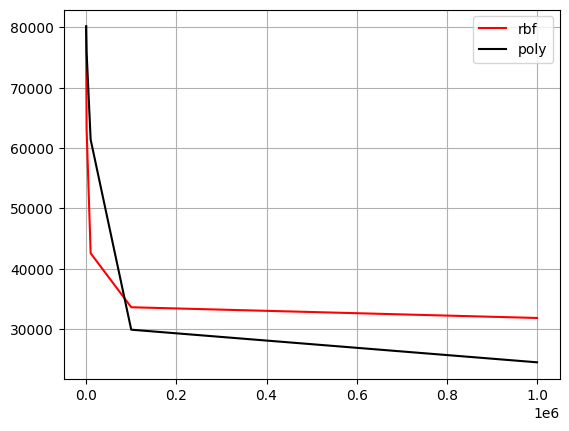

MAE: 18482.3083207596
MRSE: 30185.06717743604


In [17]:
from sklearn.svm import SVR

nrange = 10.0 ** np.arange(-2, 7)
params = ['rbf', 'poly']

for j, c in zip(params, ['red', 'black']):
  errors = []
  for i in nrange:
    print(j, i, end='/')
    svr = SVR(kernel=j, C=i)
    svr.fit(scaled_X_train, y_train)

    preds = svr.predict(scaled_X_test)
    errors.append((mean_absolute_error(y_test, preds) +
                  np.sqrt(mean_squared_error(y_test, preds))) / 2)

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.grid(True)
plt.show()

test_model(SVR(C=10**7, kernel='poly'))   # Rbf is lacking in this dataset

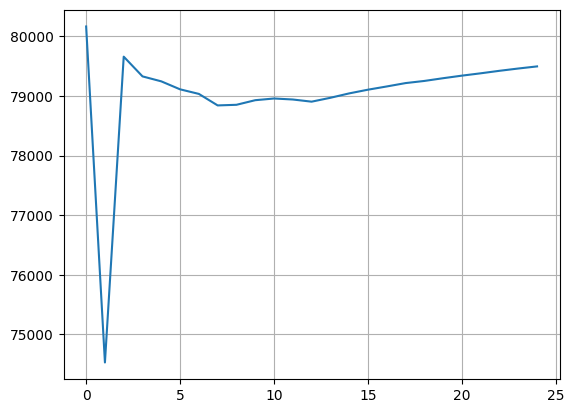

MAE: 62439.53433324565
MRSE: 96845.87808353681


In [6]:
from sklearn.svm import SVR

errors = []
nrange = list(range(25))


for i in nrange:
  print(i, end='/')
  svr = SVR(kernel='poly', degree=i, C=100)
  svr.fit(scaled_X_train, y_train)

  preds = svr.predict(scaled_X_test)
  errors.append((mean_absolute_error(y_test, preds) +
                np.sqrt(mean_squared_error(y_test, preds))) / 2)

clear_output()

plt.plot(nrange, errors)
plt.grid(True)
plt.show()  # The most efficient degree lowers with the increase of C

test_model(SVR(kernel='poly', degree=12))  # The most efficient degree for the C of one

In [11]:
from sklearn.linear_model import LinearRegression

test_model(LinearRegression())  # Ok, I guess

MAE: 20884.64164162836
MRSE: 35109.95319098902


In [12]:
from sklearn.linear_model import ElasticNet

test_model(ElasticNet(alpha=1, l1_ratio=1, max_iter=10**8))  #Worse then linear and too many factors to analyze

MAE: 20969.107758038925
MRSE: 35177.18992927507


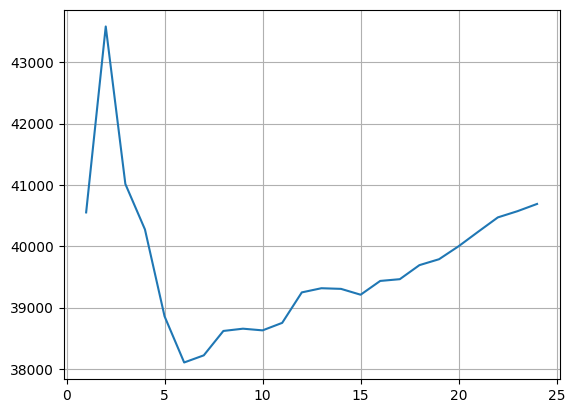

MAE: 26519.063600782785
MRSE: 49925.001716915576


In [9]:
from sklearn.neighbors import KNeighborsRegressor

errors = []
nrange = list(range(1, 25))


for i in nrange:
  print(i, end='/')
  knn = KNeighborsRegressor(i)
  knn.fit(scaled_X_train, y_train)

  preds = knn.predict(scaled_X_test)
  errors.append((mean_absolute_error(y_test, preds) +
                np.sqrt(mean_squared_error(y_test, preds))) / 2)

clear_output()

plt.plot(nrange, errors)
plt.grid(True)
plt.show()

test_model(KNeighborsRegressor(7))    # Wow, terrible

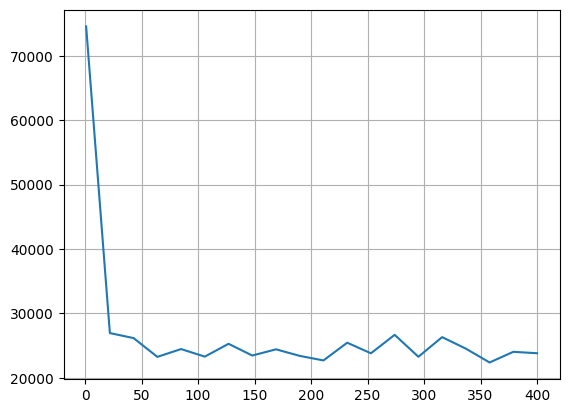

MAE: 16445.10846370881
MRSE: 30171.98112661239


In [15]:
from sklearn.ensemble import GradientBoostingRegressor

errors = []
nrange = np.linspace(1, 400, 20).astype(int)


for i in nrange:
  print(i, end='/')
  gbr = GradientBoostingRegressor(n_estimators=i, max_features=50, max_depth=12)
  gbr.fit(scaled_X_train, y_train)

  preds = gbr.predict(scaled_X_test)
  errors.append((mean_absolute_error(y_test, preds) +
                np.sqrt(mean_squared_error(y_test, preds))) / 2)

clear_output()

plt.plot(nrange, errors)
plt.grid(True)
plt.show()

test_model(GradientBoostingRegressor(n_estimators=200))    # Pretty good compared to others

In [22]:
param_grid = {
            'loss' : ['squared_error', 'absolute_error','huber', 'quantile'],
            'learning_rate' : [.01, .1, .5, 1],
            'criterion' : ['friedman_mse', 'squared_error']
             }

gbr_grid = test_grid(GradientBoostingRegressor(n_estimators=200, max_depth=12, max_features=50),
                     param_grid,
                     cv=4,
                     return_model=True,
                     verbose=1)   # Worsened it a little, MAE is smaller though

Fitting 4 folds for each of 32 candidates, totalling 128 fits
MAE: 15807.1465110539
MRSE: 31656.29333658833
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'absolute_error'}


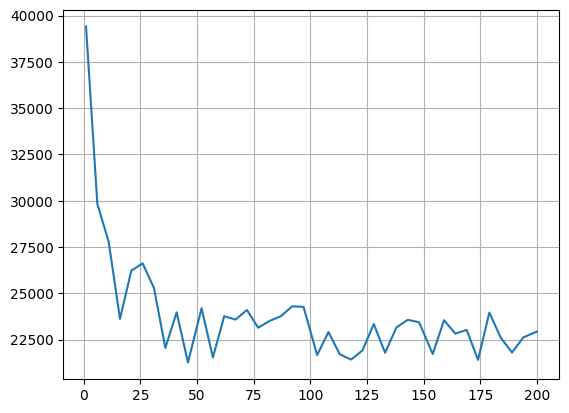

MAE: 15972.217707965383
MRSE: 29605.825312232446


In [44]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

errors = []
nrange = np.linspace(1, 200, 0).astype(int)


for i in nrange:
  print(i, end='/')
  ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=12, max_features=50), n_estimators=i)
  ada.fit(scaled_X_train, y_train)

  preds = ada.predict(scaled_X_test)
  errors.append((mean_absolute_error(y_test, preds) +
                np.sqrt(mean_squared_error(y_test, preds))) / 2)

clear_output()

plt.plot(nrange, errors)
plt.grid(True)
plt.show()

test_model(AdaBoostRegressor(DecisionTreeRegressor(max_depth=12, max_features=50), n_estimators=100))    # Better for MRSE

In [46]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

mmscaler = MinMaxScaler().fit(X_train)

mmscaled_X_train = mmscaler.transform(X_train)
mmscaled_X_test = mmscaler.transform(X_test)
mmscaled_X = mmscaler.fit_transform(X)

mmscaled_test = scaler.transform(test_dum)

gnb = GaussianNB().fit(mmscaled_X_train, y_train)

preds = gnb.predict(mmscaled_X_test)

print('MAE:', mean_absolute_error(y_test, preds))
print('MRSE:', np.sqrt(mean_squared_error(y_test, preds)))    # Terrible

MAE: 45962.349315068495
MRSE: 84975.93226775434


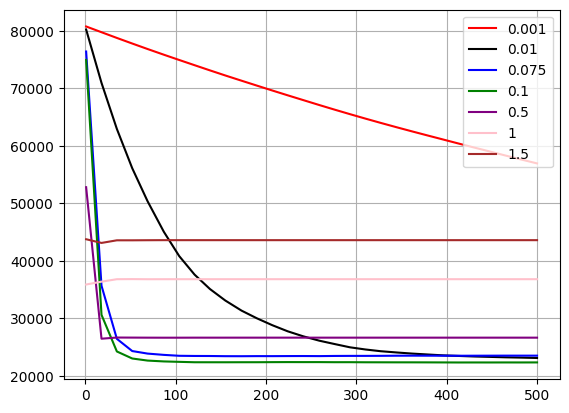

MAE: 16679.85375642123
MRSE: 29886.90089025392


In [59]:
from xgboost import XGBRegressor

errors = []
nrange = np.linspace(1, 500, 30).astype(int)
params = [.001, .01, .075, .1, .5, 1, 1.5]

for j, c in zip(params, ['red', 'black', 'blue', 'green', 'purple', 'pink', 'brown']):
  errors = []
  for i in nrange:
    print(j, i, end='/')

    xgb = XGBRegressor(learning_rate=j, n_estimators=i)
    xgb.fit(scaled_X_train, y_train)

    preds = xgb.predict(scaled_X_test)
    errors.append((mean_absolute_error(y_test, preds) +
                  np.sqrt(mean_squared_error(y_test, preds))) / 2)

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.grid(True)
plt.show()


test_model(XGBRegressor())    # Learning rate of .01 is the best with n > 500

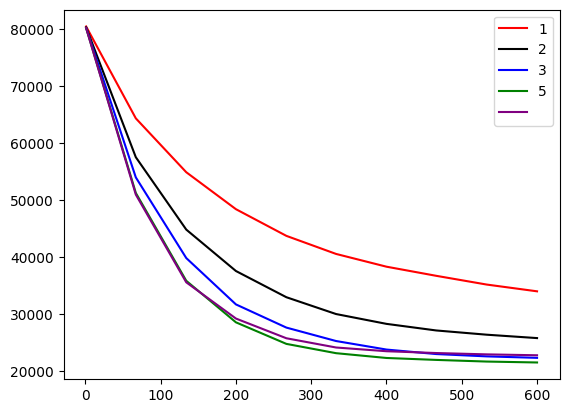

MAE: 14970.891614940068
MRSE: 27441.614576285898


In [10]:
from xgboost import XGBRegressor

nrange = np.linspace(1, 600, 10).astype(int)
params = [1, 2, 3, 5, None]

for j, c in zip(params, ['red', 'black', 'blue', 'green', 'purple']):
  errors = []
  for i in nrange:
    print(j, i, end='/')
    xgb = XGBRegressor(n_estimators=i, max_depth=j, learning_rate=.01)
    xgb.fit(scaled_X_train, y_train)

    preds = xgb.predict(scaled_X_test)
    errors.append((mean_absolute_error(y_test, preds) +
                  np.sqrt(mean_squared_error(y_test, preds))) / 2)

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.grid(True)
plt.show()

test_model(XGBRegressor(learning_rate=.01, n_estimators=1000, max_depth=5))   # The last one is the most balanced between MRSE and MAE

In [9]:
from xgboost import XGBRegressor

test_grid(XGBRegressor(learning_rate=.01, n_estimators=1000, max_depth=5, device='cuda'),
           {'gamma' : [.01, .1, 0],
            'min_child_weight' : [.01, .1, 0],
            'max_delta_step' : [.01, .1, 0]},
          cv=5,
          verbose=1)    # Same as the default one

Fitting 5 folds for each of 27 candidates, totalling 135 fits
MAE: 14970.889233732876
MRSE: 27441.642429731182
{'gamma': 0.01, 'max_delta_step': 0, 'min_child_weight': 0.01}


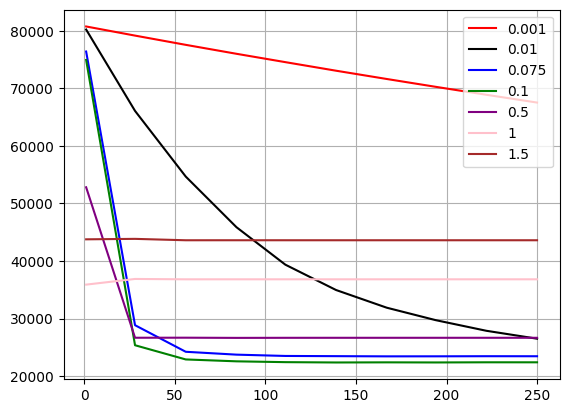

MAE: 16679.85375642123
MRSE: 29886.90089025392


In [7]:
from xgboost import XGBRegressor

errors = []
nrange = np.linspace(1, 250, 10).astype(int)
params = [.001, .01, .075, .1, .5, 1, 1.5]

for j, c in zip(params, ['red', 'black', 'blue', 'green', 'purple', 'pink', 'brown']):
  errors = []
  for i in nrange:
    print(j, i, end='/')

    xgb = XGBRegressor(booster='dart', device='cuda', learning_rate=j, n_estimators=i)
    xgb.fit(scaled_X_train, y_train)

    preds = xgb.predict(scaled_X_test)
    errors.append((mean_absolute_error(y_test, preds) +
                  np.sqrt(mean_squared_error(y_test, preds))) / 2)

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.grid(True)
plt.show()

# GBtree works worse, and this one performs just slightly worse than the GBtree

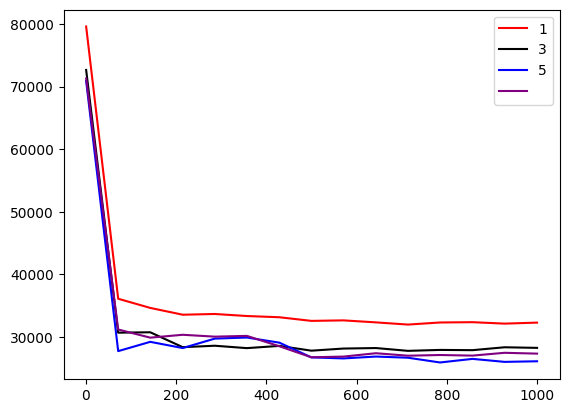

MAE: 16014.823922250089
MRSE: 26111.308152554502


In [33]:
from catboost import CatBoostRegressor

nrange = np.linspace(1, 1000, 15).astype(int)
params = [1, 3, 5, None]

for j, c in zip(params, ['red', 'black', 'blue', 'purple']):
  errors = []
  for i in nrange:
    print(j, i, end='/')
    cat = CatBoostRegressor(max_depth=j, n_estimators=i, verbose=0, task_type='GPU')
    cat.fit(scaled_X_train, y_train)

    preds = cat.predict(scaled_X_test)
    errors.append(np.sqrt(mean_squared_error(y_test, preds)))

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.grid(True)
plt.show()

test_model(CatBoostRegressor(n_estimators=1000, max_depth=5, task_type='GPU', verbose=0))   # Great! The MAE is better with XGBoost though, might need to use votingregressor later

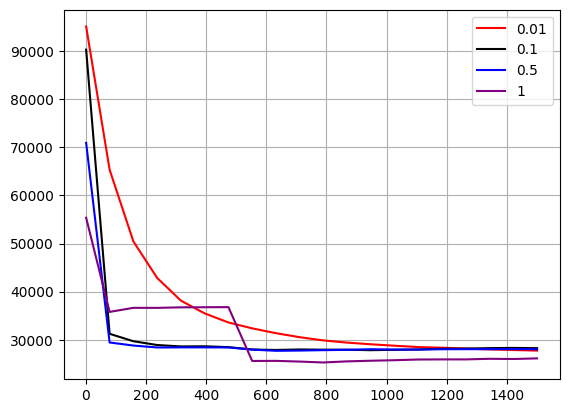

MAE: 16814.487310411037
MRSE: 25824.920593751056


In [36]:
from catboost import CatBoostRegressor

nrange = np.linspace(1, 1500, 20).astype(int)
params = [.01, .1, .5, 1, 2]

for j, c in zip(params, ['red', 'black', 'blue', 'purple']):
  errors = []
  for i in nrange:
    print(j, i, end='/')
    cat = CatBoostRegressor(max_depth=5, n_estimators=i, verbose=0, learning_rate=j, task_type='GPU')
    cat.fit(scaled_X_train, y_train)

    preds = cat.predict(scaled_X_test)
    errors.append(np.sqrt(mean_squared_error(y_test, preds)))

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.grid(True)
plt.show()

test_model(CatBoostRegressor(n_estimators=600, max_depth=5, learning_rate=1, task_type='GPU', verbose=0))   # A slight improvement, the 1 learning rate curve is aslo pecuiar

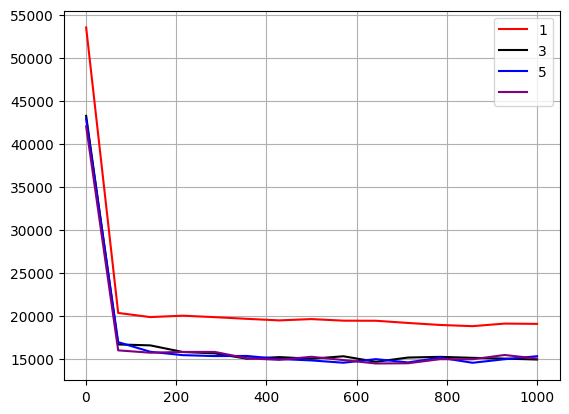

MAE: 14459.572455656702
MRSE: 26742.98873854038


In [67]:
from catboost import CatBoostRegressor

nrange = np.linspace(1, 1000, 15).astype(int)
params = [1, 3, 5, None]

for j, c in zip(params, ['red', 'black', 'blue', 'purple']):
  errors = []
  for i in nrange:
    print(j, i, end='/')
    cat = CatBoostRegressor(max_depth=j, n_estimators=i, grow_policy='Lossguide', verbose=0, task_type='GPU')   # Lossguide seems to be the best option for MAE
    cat.fit(scaled_X_train, y_train)

    preds = cat.predict(scaled_X_test)
    errors.append(mean_absolute_error(y_test, preds))

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.grid(True)
plt.show()

test_model(CatBoostRegressor(n_estimators=600, task_type='GPU',  grow_policy='Lossguide', verbose=0))

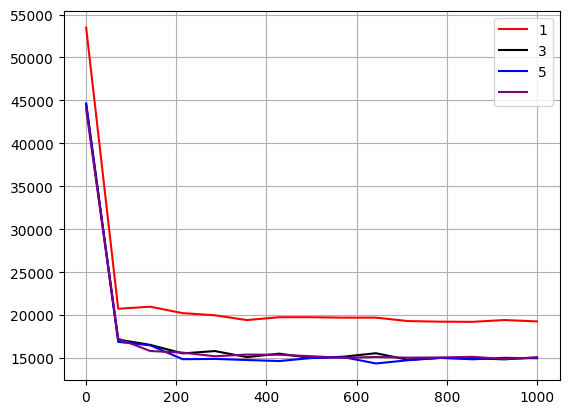

MAE: 14746.772646709514
MRSE: 28562.361255605585


In [68]:
from catboost import CatBoostRegressor

nrange = np.linspace(1, 1000, 15).astype(int)
params = [1, 3, 5, None]

for j, c in zip(params, ['red', 'black', 'blue', 'purple']):
  errors = []
  for i in nrange:
    print(j, i, end='/')
    cat = CatBoostRegressor(max_depth=j, n_estimators=i, grow_policy='Depthwise', verbose=0, task_type='GPU')   # Losttguide seems to be the best option for MAE
    cat.fit(scaled_X_train, y_train)

    preds = cat.predict(scaled_X_test)
    errors.append(mean_absolute_error(y_test, preds))

  plt.plot(nrange, errors, color=c)

clear_output()

plt.legend(params)
plt.grid(True)
plt.show()

test_model(CatBoostRegressor(n_estimators=630, grow_policy='Depthwise', max_depth=5, task_type='GPU', verbose=0))   # Worse with lossguide

In [74]:
from sklearn.ensemble import VotingRegressor

vr = test_model(VotingRegressor([('cat1', CatBoostRegressor(n_estimators=600, task_type='GPU',  grow_policy='Lossguide', verbose=0)),
                            ('cat2', CatBoostRegressor(n_estimators=600, max_depth=5, learning_rate=1, task_type='GPU', verbose=0)),
                            ('xgb', XGBRegressor(learning_rate=.01, n_estimators=1000, max_depth=5))]),
                return_model=True)    # Works amazing together!


MAE: 13892.713798235682
MRSE: 24880.757674455366


In [92]:
best = vr.fit(scaled_X, y)
preds = best.predict(scaled_test)

sub = pd.DataFrame({'Id': test_dum.set_index('Id').index.astype(int), 'SalePrice': preds})
sub = sub.set_index('Id')

sub.to_csv('houses_sub.csv')    # Final score of 14113